### Ensamble
- BackwardDifferenceEncoder

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils.base_models import BaseModels
from utils.categorical_encoders import CategoricalEncoders

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [31]:
# 0. Definir seed
seed = 16
np.random.seed(seed)

In [32]:
# 1. Leer el dataset
dataset = pd.read_parquet('./data/2_data_preprocesada.parquet')
dataset = dataset.drop(columns=['DF_TYPE'])

# Seleccionar aleatoriamente el 10% de los datos
dataset = dataset.sample(frac=0.002, random_state=42)
print(dataset.shape)
print(dataset['TARGET'].value_counts())

(2611, 14)
TARGET
0    1371
1    1240
Name: count, dtype: int64


In [33]:
# 2. Crear dataset con los encoders
categorical_encoders = CategoricalEncoders(dataset=dataset)
binary_columns, categorical_columns = categorical_encoders.get_binary_categorical_columns()

data = categorical_encoders.provider(binary_columns, categorical_columns, method='BackwardDifferenceEncoder')

In [34]:
# 3. Split dataset
X = data.drop(columns=['TARGET'])
y = data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [35]:
# 4. Entrenar modelos
base_models = BaseModels()
name_models = ['logistic_regression', 'gradient_boosting', 'catboost', 'lgbm', 'xgboost', 'mlp', 'decision_tree']

all_models = []
all_results = []
all_predict_test = []
for i, model_name in enumerate(name_models):
    model = base_models.provider(model_name)
    model.fit(X_train, y_train)
    all_models.append(model)
    
    predict_train = model.predict_proba(X_train)[:, 1]
    predict_test = model.predict_proba(X_test)[:, 1]
    all_predict_test.append(predict_test)

    train_auc = roc_auc_score(y_train, predict_train)
    test_auc = roc_auc_score(y_test, predict_test)

    # Calculate accuracy, sensitivity, specificity
    test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    gini = 2 * test_auc - 1

    all_results.append((model_name, train_auc, test_auc, accuracy, sensitivity, specificity, gini))

    print(f"{str(i).zfill(2)}: AUC on training data with {model_name}: {train_auc:.3f}")
    print(f"AUC on testing data with {model_name}: {test_auc:.3f}\n")

# Desempaquetar los resultados
names, train_aucs, test_aucs, accuracies, sensitivities, specificities, ginis = zip(*all_results)


00: AUC on training data with logistic_regression: 0.816
AUC on testing data with logistic_regression: 0.776

01: AUC on training data with gradient_boosting: 0.893
AUC on testing data with gradient_boosting: 0.818

02: AUC on training data with catboost: 0.942
AUC on testing data with catboost: 0.823

[LightGBM] [Info] Number of positive: 982, number of negative: 1106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 2088, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470307 -> initscore=-0.118914
[LightGBM] [Info] Start training from score -0.118914
03: AUC on training data with lgbm: 0.971
AUC on testing data with lgbm: 0.808

04: AUC on training data with xgboost: 0.985
AUC on testing dat

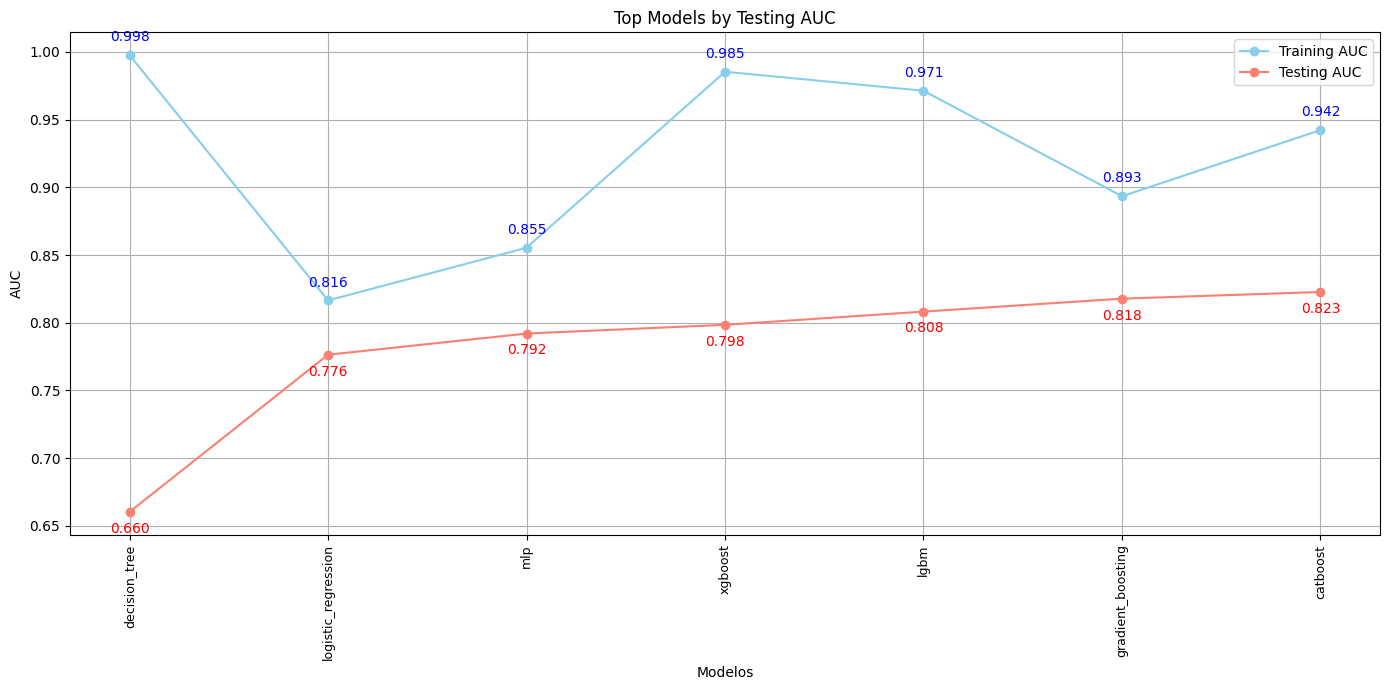

In [36]:
# Ordenar los resultados
sorted_results = sorted(all_results, key=lambda x: x[2], reverse=False)
top_results = sorted_results[:15]

# Desempaquetar los resultados del top
top_names, top_train_aucs, top_test_aucs, top_accuracies, top_sensitivities, top_specificities, top_ginis = zip(*top_results)

plt.figure(figsize=(14, 7))

# Gráfico de líneas para el top
plt.plot(top_names, top_train_aucs, label='Training AUC', marker='o', color='skyblue')
plt.plot(top_names, top_test_aucs, label='Testing AUC', marker='o', color='salmon')

# Añadir los valores a los puntos
for i, txt in enumerate(top_train_aucs):
    plt.annotate(f'{txt:.3f}', (top_names[i], top_train_aucs[i]), textcoords="offset points", xytext=(0, 10), ha='center', color='blue')
for i, txt in enumerate(top_test_aucs):
    plt.annotate(f'{txt:.3f}', (top_names[i], top_test_aucs[i]), textcoords="offset points", xytext=(0, -15), ha='center', color='red')

plt.xlabel('Modelos')
plt.ylabel('AUC')
plt.title('Top Models by Testing AUC')
plt.xticks(rotation=90, fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Ensamble
1. logistic_regression
2. gradient_boosting 
3. catboost
4. lgbm
5. xgboost

#### A. Voting

In [39]:
model = VotingClassifier(estimators=[(name_models[0], all_models[0])
                                    ,(name_models[1], all_models[1])
                                    ,(name_models[2], all_models[2])]
                                    , voting='soft')
model.fit(X_train,y_train)

VotingClassifier(estimators=[('logistic_regression',
                              LogisticRegression(random_state=42)),
                             ('gradient_boosting',
                              GradientBoostingClassifier(random_state=42)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x357a745e0>)],
                 voting='soft')

In [40]:
VotingClassifier_test_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, VotingClassifier_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, VotingClassifier_test_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
gini = 2 * roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) - 1
print("Accuracy on testing: {:.3f}".format(accuracy))

finalpred_Averaging = (all_predict_test[0] + all_predict_test[1] + all_predict_test[2]) / 3
auc_averaging = roc_auc_score(y_test, finalpred_Averaging)
print("auc on testing in Averaging data : {:.3f}".format(auc_averaging))

finalpred_W_Averaging = (all_predict_test[0] * 0.5 + all_predict_test[1] * 0.2 + all_predict_test[2] * 0.3) / 3
auc_weighted_averaging = roc_auc_score(y_test, finalpred_W_Averaging)
print("auc on testing in Weighted Average data : {:.3f}".format(auc_weighted_averaging))

# Guardar resultados
model_name = 'voting_classifier_3_models'
train_auc = 0
test_auc = max(auc_averaging, auc_weighted_averaging)
all_results.append((model_name, train_auc, test_auc, accuracy, sensitivity, specificity, gini))

Accuracy on testing: 0.750
auc on testing in Averaging data : 0.814
auc on testing in Weighted Average data : 0.807


In [43]:
model = VotingClassifier(estimators=[(name_models[0], all_models[0])
                                    ,(name_models[1], all_models[1])
                                    ,(name_models[2], all_models[2])
                                    ,(name_models[3], all_models[3])
                                    ,(name_models[4], all_models[4])]
                                    , voting='soft')
model.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 982, number of negative: 1106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 2088, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470307 -> initscore=-0.118914
[LightGBM] [Info] Start training from score -0.118914


VotingClassifier(estimators=[('logistic_regression',
                              LogisticRegression(random_state=42)),
                             ('gradient_boosting',
                              GradientBoostingClassifier(random_state=42)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x357a745e0>),
                             ('lgbm', LGBMClassifier(random_state=42)),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [44]:
VotingClassifier_test_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, VotingClassifier_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, VotingClassifier_test_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
gini = 2 * roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) - 1
print("Accuracy on testing: {:.3f}".format(accuracy))

finalpred_Averaging = (all_predict_test[0] + all_predict_test[1] + all_predict_test[2] + all_predict_test[3] + all_predict_test[4]) / 5
auc_averaging = roc_auc_score(y_test, finalpred_Averaging)
print("auc on testing in Averaging data : {:.3f}".format(auc_averaging))

finalpred_W_Averaging = (all_predict_test[0] * 0.5 + all_predict_test[1] * 0.2 + all_predict_test[2] * 0.3 + all_predict_test[3] * 0.1 + all_predict_test[4] * 0.4) / 5
auc_weighted_averaging = roc_auc_score(y_test, finalpred_W_Averaging)
print("auc on testing in Weighted Average data : {:.3f}".format(auc_weighted_averaging))

# Guardar resultados
model_name = 'voting_classifier_5_models'
train_auc = 0
test_auc = max(auc_averaging, auc_weighted_averaging)
all_results.append((model_name, train_auc, test_auc, accuracy, sensitivity, specificity, gini))


Accuracy on testing: 0.753
auc on testing in Averaging data : 0.816
auc on testing in Weighted Average data : 0.813


#### B. Stacking

In [45]:
estimators = [(name_models[0], all_models[0]),
              (name_models[1], all_models[1]),
              (name_models[2], all_models[2])]

stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking.fit(X_train, y_train)

stacking_test_pred = stacking.predict(X_test)
stacking_test_prod = stacking.predict_proba(X_test)[:, 1]

In [46]:
# Print scores on both
accuracy = accuracy_score(y_test, stacking_test_pred)
test_auc = roc_auc_score(y_test, stacking_test_prod)
tn, fp, fn, tp = confusion_matrix(y_test, stacking_test_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
gini = 2 * test_auc - 1
print("accuracy on testing in Stacking data : {:.3f}".format(accuracy))
print("auc on testing in Stacking data : {:.3f}".format(test_auc))

# Guardar resultados
model_name = 'stacking_classifier_3_models'
train_auc = 0
all_results.append((model_name, train_auc, test_auc, accuracy, sensitivity, specificity, gini))


accuracy on testing in Stacking data : 0.748
auc on testing in Stacking data : 0.816


In [47]:
# Stacking with 5 models
estimators = [(name_models[0], all_models[0]),
              (name_models[1], all_models[1]),
              (name_models[2], all_models[2]),
              (name_models[3], all_models[3]),
              (name_models[4], all_models[4])]

stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking.fit(X_train, y_train)

stacking_test_pred = stacking.predict(X_test)
stacking_test_prod = stacking.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 982, number of negative: 1106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 2088, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470307 -> initscore=-0.118914
[LightGBM] [Info] Start training from score -0.118914
[LightGBM] [Info] Number of positive: 785, number of negative: 885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 1670, number of used features: 28
[LightGBM] [Info] [binary:Boo

In [48]:
# Print scores on both
accuracy = accuracy_score(y_test, stacking_test_pred)
test_auc = roc_auc_score(y_test, stacking_test_prod)
tn, fp, fn, tp = confusion_matrix(y_test, stacking_test_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
gini = 2 * test_auc - 1
print("accuracy on testing in Stacking data : {:.3f}".format(accuracy))
print("auc on testing in Stacking data : {:.3f}".format(test_auc))

# Guardar resultados
model_name = 'stacking_classifier_5_models'
train_auc = 0
all_results.append((model_name, train_auc, test_auc, accuracy, sensitivity, specificity, gini))


accuracy on testing in Stacking data : 0.763
auc on testing in Stacking data : 0.814


#### C. Bagging

In [49]:
bagging = BaggingClassifier(n_estimators=50, random_state=0)
bagging.fit(X_train, y_train)

bagging_test_pred = bagging.predict(X_test)
bagging_test_prob = bagging.predict_proba(X_test)[:, 1]

# Print scores on both
accuracy = accuracy_score(y_test, bagging_test_pred)
test_auc = roc_auc_score(y_test, bagging_test_prob)
tn, fp, fn, tp = confusion_matrix(y_test, bagging_test_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
gini = 2 * test_auc - 1
print("accuracy on testing in BaggingClassifier data : {:.3f}".format(accuracy))
print("auc on testing in BaggingClassifier data : {:.3f}".format(test_auc))

# Guardar resultados
model_name = 'bagging_classifier'
train_auc = 0
all_results.append((model_name, train_auc, test_auc, accuracy, sensitivity, specificity, gini))

accuracy on testing in BaggingClassifier data : 0.734
auc on testing in BaggingClassifier data : 0.785


In [50]:
# Bagging with DecisionTree
base_model = DecisionTreeClassifier()
bagging_model = BaggingClassifier(estimator=base_model, n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)

predict_train = bagging_model.predict_proba(X_train)[:, 1]
predict_test = bagging_model.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, predict_train)
test_auc = roc_auc_score(y_test, predict_test)

bagging_test_pred = bagging_model.predict(X_test)
accuracy = accuracy_score(y_test, bagging_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, bagging_test_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
gini = 2 * test_auc - 1
print(f"AUC on training data with Bagging: {train_auc:.3f}")
print(f"AUC on testing data with Bagging: {test_auc:.3f}")

# Guardar resultados
model_name = 'bagging_classifier_decision_tree'
all_results.append((model_name, train_auc, test_auc, accuracy, sensitivity, specificity, gini))


AUC on training data with Bagging: 0.993
AUC on testing data with Bagging: 0.792


In [51]:
# Votting Model
voting_model = VotingClassifier(estimators=[(name_models[0], all_models[0]),
                                            (name_models[1], all_models[1]),
                                            (name_models[2], all_models[2])],
                                voting='soft')
voting_model.fit(X_train, y_train)

# Stacking Model
estimators = [(name_models[0], all_models[0]),
              (name_models[1], all_models[1]),
              (name_models[2], all_models[2])]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)

# Bagging Model
bagging_model = BaggingClassifier(estimator=all_models[0], n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)

# Evaluar modelos de ensamble
ensemble_models = [('Voting', voting_model), ('Stacking', stacking_model), ('Bagging', bagging_model)]

for name, model in ensemble_models:
    predict_train = model.predict_proba(X_train)[:, 1]
    predict_test = model.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train, predict_train)
    test_auc = roc_auc_score(y_test, predict_test)

    test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    gini = 2 * test_auc - 1

    print(f"AUC on training data with {name}: {train_auc:.3f}")
    print(f"AUC on testing data with {name}: {test_auc:.3f}\n")

    # Guardar resultados
    model_name = f'{name.lower()}__classifier'
    all_results.append((model_name, train_auc, test_auc, accuracy, sensitivity, specificity, gini))


AUC on training data with Voting: 0.902
AUC on testing data with Voting: 0.814

AUC on training data with Stacking: 0.916
AUC on testing data with Stacking: 0.816

AUC on training data with Bagging: 0.818
AUC on testing data with Bagging: 0.780



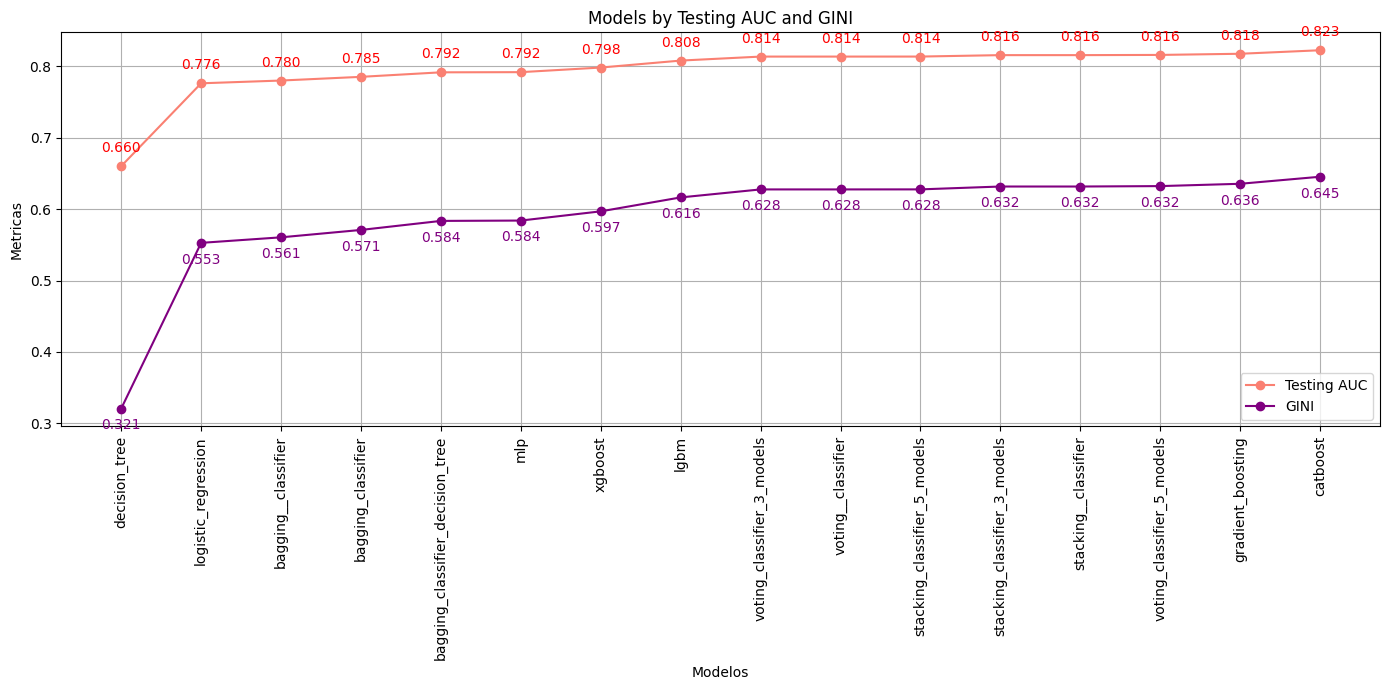

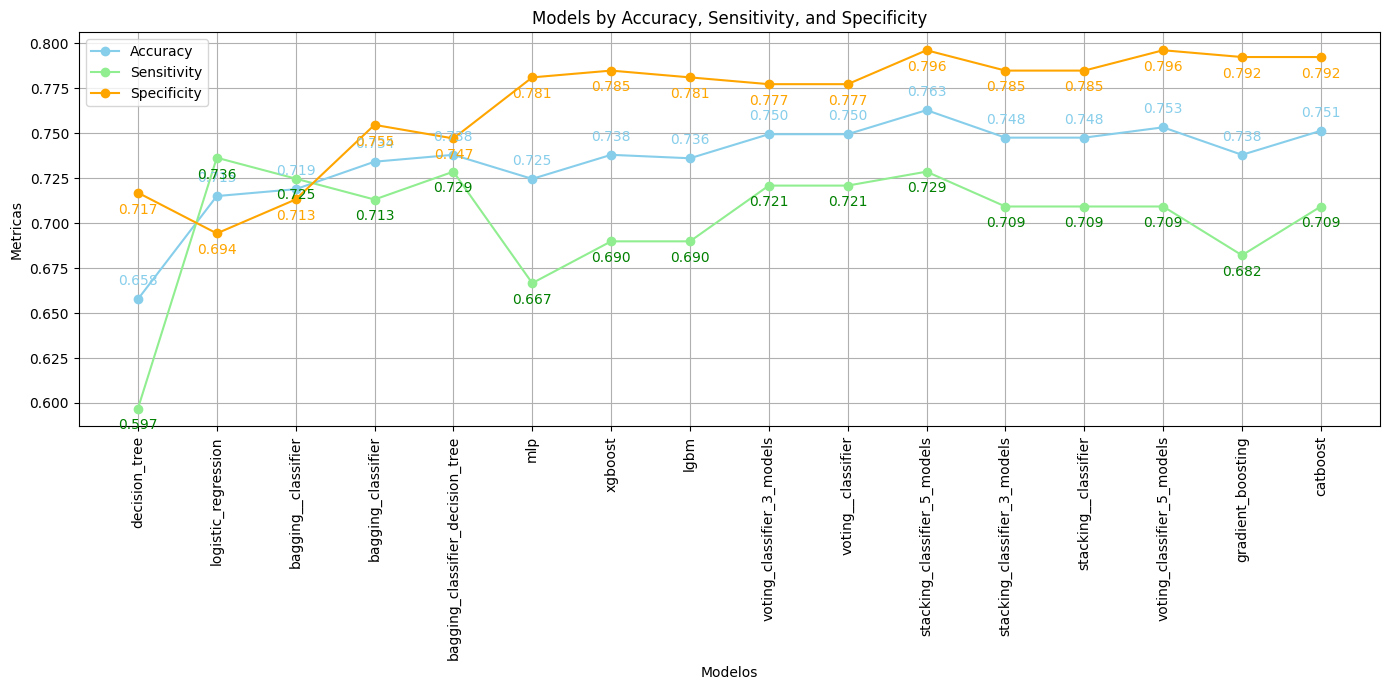

In [54]:
# Consolidar todos los resultados en una lista
consolidated_results = [(model_name, test_auc, accuracy, sensitivity, specificity, gini) for model_name, _, test_auc, accuracy, sensitivity, specificity, gini in all_results]

# Ordenar los resultados por test_auc de mayor a menor
consolidated_results.sort(key=lambda x: x[1], reverse=False)

# Desempaquetar los resultados
all_names, all_test_aucs, all_accuracies, all_sensitivities, all_specificities, all_ginis = zip(*consolidated_results)

# Gráfico 1: GINI y AUC
plt.figure(figsize=(14, 7))

plt.plot(all_names, all_test_aucs, label='Testing AUC', marker='o', color='salmon')
plt.plot(all_names, all_ginis, label='GINI', marker='o', color='purple')

# Añadir los valores a los puntos
for i, txt in enumerate(all_test_aucs):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_test_aucs[i]), textcoords="offset points", xytext=(0, 10), ha='center', color='red')
for i, txt in enumerate(all_ginis):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_ginis[i]), textcoords="offset points", xytext=(0, -15), ha='center', color='purple')

plt.xlabel('Modelos')
plt.ylabel('Metricas')
plt.title('Models by Testing AUC and GINI')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 2: Accuracy, Sensitivity y Specificity
plt.figure(figsize=(14, 7))

plt.plot(all_names, all_accuracies, label='Accuracy', marker='o', color='skyblue')
plt.plot(all_names, all_sensitivities, label='Sensitivity', marker='o', color='lightgreen')
plt.plot(all_names, all_specificities, label='Specificity', marker='o', color='orange')

# Añadir los valores a los puntos
for i, txt in enumerate(all_accuracies):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_accuracies[i]), textcoords="offset points", xytext=(0, 10), ha='center', color='skyblue')
for i, txt in enumerate(all_sensitivities):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_sensitivities[i]), textcoords="offset points", xytext=(0, -15), ha='center', color='green')
for i, txt in enumerate(all_specificities):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_specificities[i]), textcoords="offset points", xytext=(0, -15), ha='center', color='orange')

plt.xlabel('Modelos')
plt.ylabel('Metricas')
plt.title('Models by Accuracy, Sensitivity, and Specificity')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Cross validation

Fold_1
0.8074511335186162

Fold_2
0.8020878792750994

Fold_3
0.8547756940614083

Fold_4
0.7842944870255795

Fold_5
0.8397936097515929

mean: 0.8176805607264592
std: 0.02579704892940404


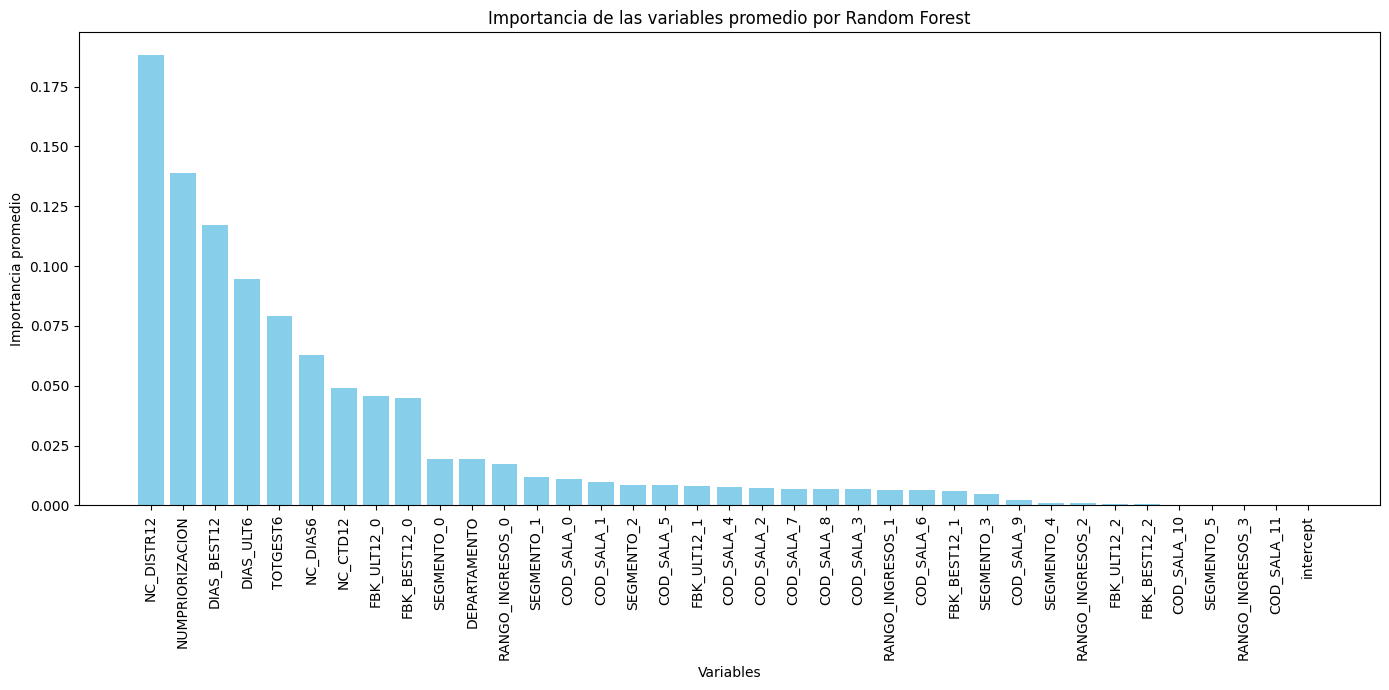

In [53]:
# Crear datasets combinados de entrenamiento y prueba
data_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
data_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

# Configurar el StratifiedKFold
kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

i = 1
r = []
features = X_train.columns
target = 'TARGET'

importancias = pd.DataFrame()
importancias['variable'] = features
i = 1

# Ejecutar el cross-validation y calcular las importancias
for train_index, test_index in kf.split(data_train[features], data_train[target]):
    rf_cv = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=2, random_state=1)
    rf_cv.fit(data_train.loc[train_index, features], data_train.loc[train_index, target])
    data_test["FOLD_" + str(i)] = rf_cv.predict_proba(data_test[features])[:, 1]

    print("Fold_" + str(i))
    a = roc_auc_score(data_train.loc[test_index, target], rf_cv.predict_proba(data_train.loc[test_index, features])[:, 1])
    r.append(a)
    print(a)
    print("")
    importancias['gain_' + str(i)] = rf_cv.feature_importances_

    i += 1

w = [x for x in importancias.columns if 'gain_' in x]

importancias['gain-avg'] = importancias[w].mean(axis=1)
importancias = importancias.sort_values('gain-avg', ascending=False).reset_index(drop=True)
importancias = importancias[['variable'] + w + ['gain-avg']]

print("mean: " + str(np.mean(np.array(r))))
print("std: " + str(np.std(np.array(r))))

# Graficar las importancias
plt.figure(figsize=(14, 7))
plt.bar(importancias['variable'], importancias['gain-avg'], color='skyblue')
plt.xlabel('Variables')
plt.ylabel('Importancia promedio')
plt.title('Importancia de las variables promedio por Random Forest')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()